In [2]:
# Import necessary libraries
import os
import cv2
import numpy as np
import kagglehub
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Layer,
    Reshape, Flatten
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import Sequence

from tensorflow.keras import mixed_precision



Path to dataset files: /kaggle/input/ucf101-action-recognition
Created directory: /kaggle/working/processed_ucf101_train
Created directory: /kaggle/working/processed_ucf101_val
Created directory: /kaggle/working/processed_ucf101_test
Starting preprocessing for Training Data...
Created directory: /kaggle/working/processed_ucf101_train/Biking
Processing class 'Biking' with 100 videos.


Processing Biking: 100%|██████████| 100/100 [00:04<00:00, 21.23it/s]


Created directory: /kaggle/working/processed_ucf101_train/GolfSwing
Processing class 'GolfSwing' with 104 videos.


Processing GolfSwing: 100%|██████████| 104/104 [00:03<00:00, 27.27it/s]


Created directory: /kaggle/working/processed_ucf101_train/PushUps
Processing class 'PushUps' with 76 videos.


Processing PushUps: 100%|██████████| 76/76 [00:01<00:00, 47.53it/s]


Created directory: /kaggle/working/processed_ucf101_train/HandstandWalking
Processing class 'HandstandWalking' with 83 videos.


Processing HandstandWalking: 100%|██████████| 83/83 [00:03<00:00, 25.66it/s]


Created directory: /kaggle/working/processed_ucf101_train/JumpingJack
Processing class 'JumpingJack' with 92 videos.


Processing JumpingJack: 100%|██████████| 92/92 [00:01<00:00, 47.53it/s]


Training data preprocessing completed.

Starting preprocessing for Validation Data...
Created directory: /kaggle/working/processed_ucf101_val/Biking
Processing class 'Biking' with 17 videos.


Processing Biking: 100%|██████████| 17/17 [00:00<00:00, 23.84it/s]


Created directory: /kaggle/working/processed_ucf101_val/GolfSwing
Processing class 'GolfSwing' with 17 videos.


Processing GolfSwing: 100%|██████████| 17/17 [00:00<00:00, 32.03it/s]


Created directory: /kaggle/working/processed_ucf101_val/PushUps
Processing class 'PushUps' with 13 videos.


Processing PushUps: 100%|██████████| 13/13 [00:00<00:00, 44.96it/s]


Created directory: /kaggle/working/processed_ucf101_val/HandstandWalking
Processing class 'HandstandWalking' with 14 videos.


Processing HandstandWalking: 100%|██████████| 14/14 [00:00<00:00, 26.86it/s]


Created directory: /kaggle/working/processed_ucf101_val/JumpingJack
Processing class 'JumpingJack' with 15 videos.


Processing JumpingJack: 100%|██████████| 15/15 [00:00<00:00, 47.94it/s]


Validation data preprocessing completed.

Starting preprocessing for Testing Data...
Created directory: /kaggle/working/processed_ucf101_test/Biking
Processing class 'Biking' with 17 videos.


Processing Biking: 100%|██████████| 17/17 [00:00<00:00, 22.36it/s]


Created directory: /kaggle/working/processed_ucf101_test/GolfSwing
Processing class 'GolfSwing' with 18 videos.


Processing GolfSwing: 100%|██████████| 18/18 [00:00<00:00, 32.64it/s]


Created directory: /kaggle/working/processed_ucf101_test/PushUps
Processing class 'PushUps' with 13 videos.


Processing PushUps: 100%|██████████| 13/13 [00:00<00:00, 52.33it/s]


Created directory: /kaggle/working/processed_ucf101_test/HandstandWalking
Processing class 'HandstandWalking' with 14 videos.


Processing HandstandWalking: 100%|██████████| 14/14 [00:00<00:00, 30.73it/s]


Created directory: /kaggle/working/processed_ucf101_test/JumpingJack
Processing class 'JumpingJack' with 16 videos.


Processing JumpingJack: 100%|██████████| 16/16 [00:00<00:00, 48.20it/s]


Testing data preprocessing completed.



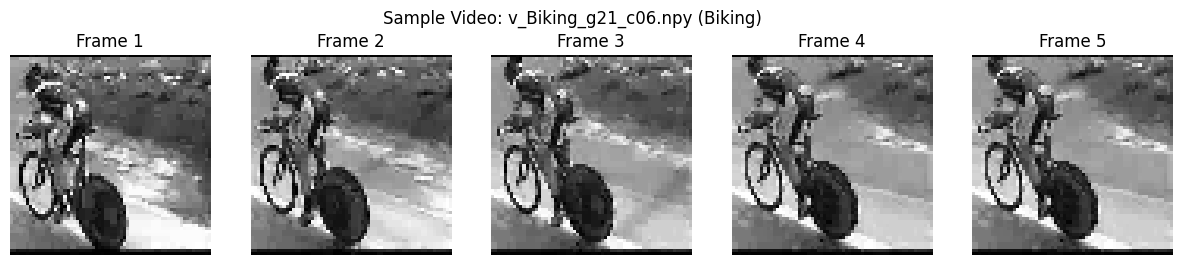

In [3]:

# -------------------------------------------------------------
# 1. Data Preprocessing
# -------------------------------------------------------------

# Define selected classes
selected_classes = ["Biking", "GolfSwing", "PushUps", "HandstandWalking", "JumpingJack"]

# Download the dataset using kagglehub
# Make sure you have configured your Kaggle API credentials
# Follow Kaggle's official guide to set up your credentials
path = kagglehub.dataset_download("matthewjansen/ucf101-action-recognition")
print("Path to dataset files:", path)

# Define paths for train, validation, and test sets
train_path = os.path.join(path, "train")
val_path = os.path.join(path, "val")
test_path = os.path.join(path, "test")

# Define output paths for processed data
output_path_train = "/kaggle/working/processed_ucf101_train"
output_path_val = "/kaggle/working/processed_ucf101_val"
output_path_test = "/kaggle/working/processed_ucf101_test"

# Preprocessing parameters
target_size = (64, 64)  # Width, Height
grayscale = True        # Convert frames to grayscale

def create_output_dirs(paths):
    """
    Create output directories if they do not exist.
    """
    for path_dir in paths:
        if not os.path.exists(path_dir):
            os.makedirs(path_dir)
            print(f"Created directory: {path_dir}")
        else:
            print(f"Directory already exists: {path_dir}")

# Create output directories for train, val, and test
create_output_dirs([output_path_train, output_path_val, output_path_test])

def process_video(video_path, target_size=(64, 64), grayscale=True):
    """
    Process a video to extract frames, resize them, and convert to grayscale if needed.

    Args:
        video_path (str): Path to the video file.
        target_size (tuple): Desired frame size (width, height).
        grayscale (bool): Whether to convert frames to grayscale.

    Returns:
        np.ndarray: Array of processed frames.
    """
    cap = cv2.VideoCapture(video_path)
    frames = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        # Resize frame
        frame = cv2.resize(frame, target_size)
        if grayscale:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frame = frame[..., np.newaxis]  # Add channel dimension
        frames.append(frame)

    cap.release()

    if len(frames) == 0:
        return None  # Return None if no frames were extracted

    frames = np.array(frames)

    return frames

def preprocess_and_save(split_path, output_path, selected_classes, target_size=(64, 64), grayscale=True):
    """
    Preprocess videos and save them as .npy files.

    Args:
        split_path (str): Path to the dataset split (train/val/test).
        output_path (str): Path to save the processed .npy files.
        selected_classes (list): List of class names to process.
        target_size (tuple): Desired frame size (width, height).
        grayscale (bool): Whether to convert frames to grayscale.
    """
    for class_name in selected_classes:
        class_input_path = os.path.join(split_path, class_name)
        class_output_path = os.path.join(output_path, class_name)

        # Create class-specific output directory
        if not os.path.exists(class_output_path):
            os.makedirs(class_output_path)
            print(f"Created directory: {class_output_path}")
        else:
            print(f"Directory already exists: {class_output_path}")

        # Iterate over all .avi files in the class directory
        video_files = [f for f in os.listdir(class_input_path) if f.endswith('.avi')]

        print(f"Processing class '{class_name}' with {len(video_files)} videos.")

        for video_file in tqdm(video_files, desc=f"Processing {class_name}"):
            video_path = os.path.join(class_input_path, video_file)
            frames = process_video(video_path, target_size, grayscale)

            if frames is not None:
                # Save the frames as a .npy file with the same base name as the video
                video_name = os.path.splitext(video_file)[0]
                output_file = os.path.join(class_output_path, f"{video_name}.npy")
                np.save(output_file, frames)
            else:
                print(f"Warning: No frames extracted from {video_path}")

# Preprocess and save training data
print("Starting preprocessing for Training Data...")
preprocess_and_save(train_path, output_path_train, selected_classes, target_size, grayscale)
print("Training data preprocessing completed.\n")

# Preprocess and save validation data
print("Starting preprocessing for Validation Data...")
preprocess_and_save(val_path, output_path_val, selected_classes, target_size, grayscale)
print("Validation data preprocessing completed.\n")

# Preprocess and save testing data
print("Starting preprocessing for Testing Data...")
preprocess_and_save(test_path, output_path_test, selected_classes, target_size, grayscale)
print("Testing data preprocessing completed.\n")

def visualize_sample(output_path, class_name, video_index=0, grayscale=True):
    """
    Visualize a sample video from the preprocessed data.

    Args:
        output_path (str): Path to the processed data.
        class_name (str): Name of the class to visualize.
        video_index (int): Index of the video within the class.
        grayscale (bool): Whether the frames are in grayscale.
    """
    class_path = os.path.join(output_path, class_name)
    video_files = [f for f in os.listdir(class_path) if f.endswith('.npy')]

    if len(video_files) == 0:
        print(f"No .npy files found in {class_path}")
        return

    if video_index >= len(video_files):
        print(f"Video index {video_index} out of range for class '{class_name}'.")
        return

    selected_video = video_files[video_index]
    video_path = os.path.join(class_path, selected_video)
    frames = np.load(video_path)

    num_frames = frames.shape[0]
    plt.figure(figsize=(15, 3))

    # Display first 5 frames or all frames if less than 5
    num_display = min(5, num_frames)
    for i in range(num_display):
        plt.subplot(1, num_display, i+1)
        if grayscale:
            plt.imshow(frames[i, :, :, 0], cmap='gray')
        else:
            plt.imshow(frames[i].astype(np.uint8))
        plt.axis('off')
        plt.title(f"Frame {i+1}")

    plt.suptitle(f"Sample Video: {selected_video} ({class_name})")
    plt.show()

# Example: Visualize the first video of the 'Biking' class in training data
visualize_sample(output_path_train, "Biking", video_index=0, grayscale=grayscale)

In [4]:

# -------------------------------------------------------------
# 2. Data Generation for Transformer
# -------------------------------------------------------------

class TransformerDataGenerator(Sequence):
    """
    Custom data generator for loading video data from .npy files in batches for Transformer model.
    Provides encoder inputs and decoder inputs (zero tensors).
    """
    def __init__(self, file_paths, batch_size=8, input_frames=10, pred_frames=5, 
                 target_size=(64, 64), channels=1, shuffle=True):
        self.file_paths = file_paths
        self.batch_size = batch_size
        self.input_frames = input_frames
        self.pred_frames = pred_frames
        self.target_size = target_size
        self.channels = channels
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return int(np.floor(len(self.file_paths) / self.batch_size))
    
    def __getitem__(self, index):
        """Generate one batch of data"""
        # Generate file paths for the current batch
        batch_files = self.file_paths[index*self.batch_size:(index+1)*self.batch_size]
        
        # Initialize lists
        encoder_batch = []
        decoder_batch = []
        target_batch = []
        
        for file_path in batch_files:
            frames = np.load(file_path)
            total_frames = frames.shape[0]
            if total_frames < self.input_frames + self.pred_frames:
                continue  # Skip if not enough frames
            
            # Randomly select a start index for the window
            start_idx = np.random.randint(0, total_frames - self.input_frames - self.pred_frames + 1)
            input_seq = frames[start_idx:start_idx + self.input_frames]
            output_seq = frames[start_idx + self.input_frames:start_idx + self.input_frames + self.pred_frames]
            
            encoder_batch.append(input_seq)
            decoder_batch.append(np.zeros_like(output_seq))  # Zero tensors as decoder inputs
            target_batch.append(output_seq)
        
        # Convert lists to numpy arrays and normalize
        encoder_batch = np.array(encoder_batch).astype('float32') / 255.
        decoder_batch = np.array(decoder_batch).astype('float32') / 255.
        target_batch = np.array(target_batch).astype('float32') / 255.
        
        # Return a tuple for inputs instead of a list
        return (encoder_batch, decoder_batch), target_batch

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle:
            np.random.shuffle(self.file_paths)

def get_all_npy_files(output_path, selected_classes):
    """
    Retrieve all .npy file paths for the specified classes.
    
    Args:
        output_path (str): Base path where processed data is stored.
        selected_classes (list): List of class names.
    
    Returns:
        list: List of full file paths to .npy files.
    """
    all_files = []
    for class_name in selected_classes:
        class_path = os.path.join(output_path, class_name)
        video_files = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.endswith('.npy')]
        all_files.extend(video_files)
    return all_files

# Retrieve file paths
train_files = get_all_npy_files(output_path_train, selected_classes)
val_files = get_all_npy_files(output_path_val, selected_classes)

print(f"Number of training files: {len(train_files)}")
print(f"Number of validation files: {len(val_files)}")

Number of training files: 455
Number of validation files: 76


In [5]:
# -------------------------------------------------------------
# 3. Transformer Model Implementation
# -------------------------------------------------------------

# Define a custom layer to print tensor shapes
class PrintShape(Layer):
    def __init__(self, name="PrintShape", **kwargs):
        super(PrintShape, self).__init__(**kwargs)
        self.name = name

    def call(self, inputs):
        print(f"{self.name} - Tensor shape: {inputs.shape}")
        return inputs

# Define Positional Encoding Layer with Frame and Patch Positional Encoding
class PositionalEncoding(Layer):
    def __init__(self, max_frames, max_patches, d_model):
        super(PositionalEncoding, self).__init__()
        self.frame_pos_encoding = self.positional_encoding(max_frames, d_model)
        self.patch_pos_encoding = self.positional_encoding(max_patches, d_model)
    
    def get_config(self):
        config = super(PositionalEncoding, self).get_config()
        config.update({
            "frame_pos_encoding": self.frame_pos_encoding.numpy(),
            "patch_pos_encoding": self.patch_pos_encoding.numpy(),
        })
        return config

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model
        )
        
        # Apply sin to even indices and cos to odd indices
        angle_rads = tf.where(
            tf.equal(tf.math.floormod(tf.range(d_model), 2), 0),
            tf.math.sin(angle_rads),
            tf.math.cos(angle_rads)
        )
        
        pos_encoding = angle_rads[tf.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)
    
    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / tf.pow(10000.0, (2.0 * (i // 2)) / tf.cast(d_model, tf.float32))
        return pos * angle_rates
    
    def call(self, inputs):
        # inputs shape: (batch_size, seq_len, num_patches, d_model)
        frame_pos = self.frame_pos_encoding[:, :tf.shape(inputs)[1], tf.newaxis, :]  # (1, seq_len, 1, d_model)
        patch_pos = self.patch_pos_encoding[:, tf.newaxis, :tf.shape(inputs)[2], :]  # (1, 1, num_patches, d_model)
        return inputs + frame_pos + patch_pos

# Define Transformer Encoder Block
class TransformerEncoderBlock(Layer):
    def __init__(self, d_model, num_heads, dff, dropout_rate=0.1):
        super(TransformerEncoderBlock, self).__init__()
        self.mha = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential([
            Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
            Dense(d_model)                  # (batch_size, seq_len, d_model)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)
    
    def call(self, x, training, mask=None):
        # Multi-head attention
        attn_output = self.mha(x, x, x, attention_mask=mask)  # Self-attention
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # Residual connection
        
        # Feed-forward network
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # Residual connection
        
        return out2

# Define Transformer Decoder Block
class TransformerDecoderBlock(Layer):
    def __init__(self, d_model, num_heads, dff, dropout_rate=0.1):
        super(TransformerDecoderBlock, self).__init__()
        self.mha1 = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.mha2 = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        
        self.ffn = tf.keras.Sequential([
            Dense(dff, activation='relu'),
            Dense(d_model)
        ])
        
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.layernorm3 = LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)
        self.dropout3 = Dropout(dropout_rate)
    
    def call(self, x, enc_output, training, look_ahead_mask=None, padding_mask=None):
        # Self-attention
        attn1 = self.mha1(x, x, x, attention_mask=look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(x + attn1)
        
        # Encoder-decoder attention
        attn2 = self.mha2(out1, enc_output, enc_output, attention_mask=padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(out1 + attn2)
        
        # Feed-forward network
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(out2 + ffn_output)
        
        return out3

# Define Patch Embedding Layer with Enhanced Debugging
class PatchEmbedding(Layer):
    def __init__(self, patch_size, d_model, frame_height, frame_width, channels):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        self.d_model = d_model
        self.num_patches = (frame_height // patch_size) * (frame_width // patch_size)
        self.proj = Dense(d_model)
    
    def call(self, x):
        """
        x: (batch_size, seq_len, height, width, channels)
        """
        batch_size = tf.shape(x)[0]
        seq_len = tf.shape(x)[1]
        height = tf.shape(x)[2]
        width = tf.shape(x)[3]
        channels = tf.shape(x)[4]
        
        # Extract patches
        patches = tf.image.extract_patches(
            images=tf.reshape(x, (-1, height, width, channels)),
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1,1,1,1],
            padding='VALID'
        )
        patch_dims = patches.shape[-1]
        
        # Explicitly use self.num_patches instead of -1
        patches = tf.reshape(patches, (batch_size, seq_len, self.num_patches, patch_dims))  # (batch_size, seq_len, num_patches, patch_dims)
        embeddings = self.proj(patches)  # (batch_size, seq_len, num_patches, d_model)
        return embeddings

# Define Transformer Model Builder without Shape Monitoring
def build_transformer_model(
    num_layers, d_model, num_heads, dff, input_frames, pred_frames,
    frame_height, frame_width, channels, patch_size, dropout_rate=0.1
):
    # Input layers
    encoder_inputs = Input(shape=(input_frames, frame_height, frame_width, channels), name='encoder_inputs')
    decoder_inputs = Input(shape=(pred_frames, frame_height, frame_width, channels), name='decoder_inputs')
    
    # Patch embedding
    patch_embed = PatchEmbedding(patch_size, d_model, frame_height, frame_width, channels)
    encoder_embeddings = patch_embed(encoder_inputs)  # (batch_size, input_frames, num_patches, d_model)
    decoder_embeddings = patch_embed(decoder_inputs)  # (batch_size, pred_frames, num_patches, d_model)
    
    # Add positional encoding with correct max_frames and max_patches
    pos_encoding = PositionalEncoding(
        max_frames=input_frames, 
        max_patches=patch_embed.num_patches, 
        d_model=d_model
    )
    encoder_embeddings = pos_encoding(encoder_embeddings)
    decoder_embeddings = pos_encoding(decoder_embeddings)
    
    # Transformer Encoder
    enc_output = encoder_embeddings
    for i in range(num_layers):
        enc_output = TransformerEncoderBlock(d_model, num_heads, dff, dropout_rate)(enc_output, training=True)
    
    # Transformer Decoder
    dec_output = decoder_embeddings
    for i in range(num_layers):
        dec_output = TransformerDecoderBlock(d_model, num_heads, dff, dropout_rate)(
            dec_output, enc_output, training=True
        )
    
    # Final projection to frame pixels
    dec_output = Dense(patch_size * patch_size * channels, activation='sigmoid')(dec_output)  # (batch_size, pred_frames, num_patches, patch_size * patch_size * channels)
    
    # Reshape to (batch_size, pred_frames, frame_height, frame_width, channels)
    dec_output = Reshape((pred_frames, frame_height, frame_width, channels))(dec_output)  # (batch_size, pred_frames, 64, 64, 1)
    
    # Define the model
    model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=dec_output, name='Transformer_Video_Prediction')
    
    # Compile the model
    optimizer = Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    model.summary()
    return model


In [6]:

# -------------------------------------------------------------
# 4. Preparing Data Generators
# -------------------------------------------------------------

# Define model parameters
NUM_LAYERS = 4
D_MODEL = 128
NUM_HEADS = 8
DFF = 512
DROPOUT_RATE = 0.1
INPUT_FRAMES = 10
PRED_FRAMES = 5
FRAME_HEIGHT = 64
FRAME_WIDTH = 64
CHANNELS = 1
PATCH_SIZE = 8
BATCH_SIZE = 8  # Adjust based on available GPU memory

# Create data generators
transformer_training_generator = TransformerDataGenerator(
    file_paths=train_files,
    batch_size=BATCH_SIZE,
    input_frames=INPUT_FRAMES,
    pred_frames=PRED_FRAMES,
    target_size=(FRAME_HEIGHT, FRAME_WIDTH),
    channels=CHANNELS,
    shuffle=True
)

transformer_validation_generator = TransformerDataGenerator(
    file_paths=val_files,
    batch_size=BATCH_SIZE,
    input_frames=INPUT_FRAMES,
    pred_frames=PRED_FRAMES,
    target_size=(FRAME_HEIGHT, FRAME_WIDTH),
    channels=CHANNELS,
    shuffle=False
)

# -------------------------------------------------------------
# 5. Building and Training the Transformer Model
# -------------------------------------------------------------

# Build the transformer model
transformer_model = build_transformer_model(
    num_layers=NUM_LAYERS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dff=DFF,
    input_frames=INPUT_FRAMES,
    pred_frames=PRED_FRAMES,
    frame_height=FRAME_HEIGHT,
    frame_width=FRAME_WIDTH,
    channels=CHANNELS,
    patch_size=PATCH_SIZE,
    dropout_rate=DROPOUT_RATE
)

# Define callbacks with .keras extension
transformer_callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('transformer_video_prediction.keras', save_best_only=True)
]


# Train the transformer model
history_transformer = transformer_model.fit(
    transformer_training_generator,
    epochs=100,  
    validation_data=transformer_validation_generator,
    callbacks=transformer_callbacks,
)

# Save the final model with .keras extension
transformer_model.save("transformer_video_prediction_final.keras")


Model: "Transformer_Video_Prediction"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ decoder_inputs      │ (None, 5, 64, 64, │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_inputs      │ (None, 10, 64,    │          0 │ -                 │
│ (InputLayer)        │ 64, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_embedding     │ (None, 5, 64,     │      8,320 │ encoder_inputs[0… │
│ (PatchEmbedding)    │ 128)              │            │ decoder_inputs[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encoding │ (None, 5, 64,     │          0 │ patch_embedding[… │
│ (PositionalEncodin… │ 128)              │            │ patch_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, 10, 64,    │    659,712 │ positional_encod… │
│ (TransformerEncode… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, 10, 64,    │    659,712 │ transformer_enco… │
│ (TransformerEncode… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, 10, 64,    │    659,712 │ transformer_enco… │
│ (TransformerEncode… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, 10, 64,    │    659,712 │ transformer_enco… │
│ (TransformerEncode… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decode… │ (None, 5, 64,     │  1,187,456 │ positional_encod… │
│ (TransformerDecode… │ 128)              │            │ transformer_enco… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decode… │ (None, 5, 64,     │  1,187,456 │ transformer_deco… │
│ (TransformerDecode… │ 128)              │            │ transformer_enco… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decode… │ (None, 5, 64,     │  1,187,456 │ transformer_deco… │
│ (TransformerDecode… │ 128)              │            │ transformer_enco… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decode… │ (None, 5, 64,     │  1,187,456 │ transformer_deco… │
│ (TransformerDecode… │ 128)              │            │ transformer_enco… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 5, 64, 64) │      8,256 │ transformer_deco… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 5, 64, 64, │          0 │ dense_17[0][0]    │
│                     │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,405,248 (28.25 MB)

 Trainable params: 7,405,248 (28.25 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1733406718.965776    2516 service.cc:145] XLA service 0x7b7310035cb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733406718.965833    2516 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733406718.965837    2516 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1733406751.683397    2571 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_96', 1348 bytes spill stores, 1348 bytes spill loads

I0000 00:00:1733406758.330422  

56/56 ━━━━━━━━━━━━━━━━━━━━ 140s 325ms/step - loss: 0.0861 - mae: 0.2401 - val_loss: 0.0592 - val_mae: 0.1982
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 276ms/step - loss: 0.0654 - mae: 0.2082 - val_loss: 0.0576 - val_mae: 0.1941
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 299ms/step - loss: 0.0625 - mae: 0.2036 - val_loss: 0.0567 - val_mae: 0.1918
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 312ms/step - loss: 0.0605 - mae: 0.2006 - val_loss: 0.0529 - val_mae: 0.1853
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 294ms/step - loss: 0.0626 - mae: 0.2061 - val_loss: 0.0520 - val_mae: 0.1801
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 286ms/step - loss: 0.0577 - mae: 0.1943 - val_loss: 0.0485 - val_mae: 0.1730
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 287ms/step - loss: 0.0509 - mae: 0.1798 - val_loss: 0.0440 - val_mae: 0.1633
Epoch 8/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 296ms/step - loss: 0.0444 - mae: 0.1649 - val_loss: 0.0401 - val_mae: 0.1523
Epoch 9/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 299ms/st

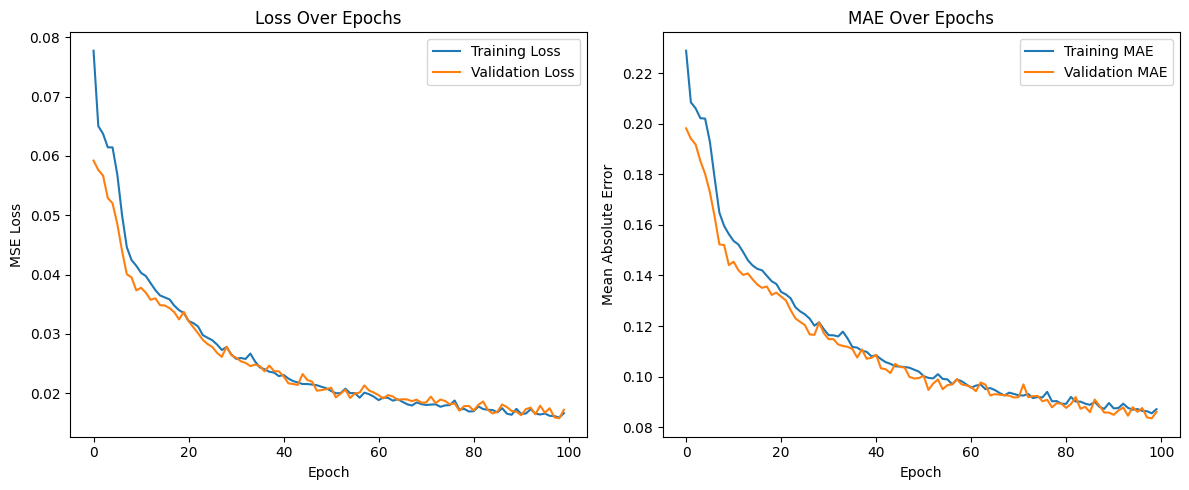

In [13]:
import matplotlib.pyplot as plt

# Assuming 'history_transformer' is the history object returned by model.fit()
history = history_transformer.history

# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history['mae'], label='Training MAE')
plt.plot(history['val_mae'], label='Validation MAE')
plt.title('MAE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.tight_layout()
plt.show()


In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import load_model


Loaded video 'JumpingJack' with 80 frames.


I0000 00:00:1733408437.605375    3923 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_94', 32 bytes spill stores, 24 bytes spill loads

I0000 00:00:1733408442.214124    3921 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_102', 32 bytes spill stores, 24 bytes spill loads



1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


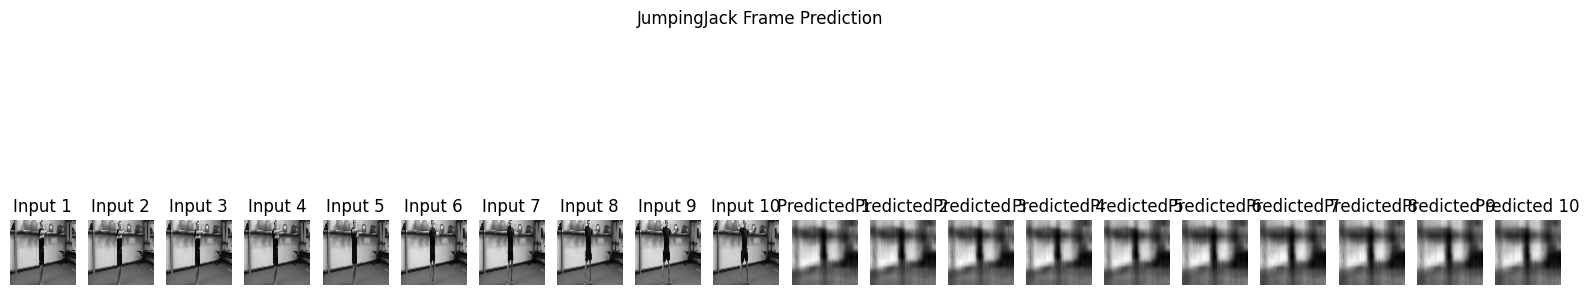

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Paths to processed data
processed_test_path = "/kaggle/working/processed_ucf101_test"

# Select the class and video to test
selected_class = "JumpingJack"
video_index = 1

# Function to load sample video
def load_sample_video(output_path, class_name, video_index=0):
    """
    Load and preprocess a sample video.

    Args:
        output_path (str): Path to the processed data.
        class_name (str): Name of the class.
        video_index (int): Index of the video within the class.

    Returns:
        np.ndarray: Array of preprocessed frames.
    """
    class_path = os.path.join(output_path, class_name)
    video_files = [f for f in os.listdir(class_path) if f.endswith('.npy')]

    if len(video_files) == 0:
        raise ValueError(f"No .npy files found in {class_path}")

    if video_index >= len(video_files):
        raise ValueError(f"Video index {video_index} out of range for class '{class_name}'.")

    selected_video = video_files[video_index]
    video_path = os.path.join(class_path, selected_video)
    frames = np.load(video_path)

    return frames  # Shape: (num_frames, 64, 64, 1)

# Load the sample video
sample_frames = load_sample_video(processed_test_path, selected_class, video_index=video_index)
print(f"Loaded video '{selected_class}' with {sample_frames.shape[0]} frames.")

# Parameters
input_frames = 10  # Number of frames for input
pred_frames = 5     # Number of frames to predict per step
total_pred_steps = 2  # Number of prediction steps

# Ensure the video has enough frames
required_frames = input_frames + pred_frames * total_pred_steps
if sample_frames.shape[0] < required_frames:
    raise ValueError(f"Selected video has only {sample_frames.shape[0]} frames, but {required_frames} are required.")

# Normalize the frames
sample_frames = sample_frames.astype('float32') / 255.0

# Select the input sequence
original_input = sample_frames[:input_frames].copy()  # Preserve original input
current_input = np.expand_dims(original_input, axis=0)  # Add batch dimension

# Function to display frames
def display_frames(input_seq, predicted_seq, video_title="Frame Prediction"):
    """
    Display the input frames and predicted frames.
    
    Args:
        input_seq (np.ndarray): Input sequence of frames, shape (N, 64, 64, 1)
        predicted_seq (np.ndarray): Predicted sequence of frames, shape (N, 64, 64, 1)
        video_title (str): Title for the plot
    """
    total_input = input_seq.shape[0]
    total_pred = predicted_seq.shape[0]
    total_frames = total_input + total_pred

    plt.figure(figsize=(20, 5))

    # Display input frames
    for i in range(total_input):
        plt.subplot(1, total_frames, i + 1)
        plt.imshow(input_seq[i, :, :, 0], cmap='gray')
        plt.title(f"Input {i+1}")
        plt.axis('off')

    # Display predicted frames
    for i in range(total_pred):
        plt.subplot(1, total_frames, total_input + i + 1)
        plt.imshow(predicted_seq[i, :, :, 0], cmap='gray')
        plt.title(f"Predicted {i+1}")
        plt.axis('off')

    plt.suptitle(video_title)
    plt.show()

# Initialize a list to store all predicted frames
predicted_frames = []

# Predict future frames
for step in range(total_pred_steps):
    # Prepare decoder input as zeros
    decoder_input = np.zeros((1, pred_frames, 64, 64, 1), dtype='float32')

    # Predict the next frames
    predicted = transformer_model.predict([current_input, decoder_input])  # Shape: (1, pred_frames, 64, 64, 1)
    predicted_frames.append(predicted[0])  # Append the predicted frames

    # Update the current input
    current_input = np.concatenate((current_input[:, pred_frames:, :, :, :], predicted), axis=1)

# Combine predicted frames
predicted_frames = np.concatenate(predicted_frames, axis=0)  # Shape: (total_pred_steps * pred_frames, 64, 64, 1)

# Denormalize the frames for visualization
input_sequence_denorm = original_input * 255.0
predicted_frames_denorm = predicted_frames * 255.0

# Display the input and predicted frames
display_frames(input_sequence_denorm, predicted_frames_denorm, video_title=f"{selected_class} Frame Prediction")


In [10]:
import cv2
import numpy as np
import os

def save_predicted_frames_to_video(frames, output_path, frame_rate=10, is_grayscale=True):
    """
    Save predicted frames as a video file.

    Args:
        frames (np.ndarray): Array of frames, shape (num_frames, height, width, channels)
        output_path (str): Path to save the video file (e.g., 'output_video.mp4')
        frame_rate (int): Frames per second in the output video
        is_grayscale (bool): Whether the frames are grayscale

    Returns:
        None
    """
    # Validate frames shape
    if frames.ndim != 4:
        raise ValueError(f"Expected frames to be a 4D array, got {frames.ndim}D array instead.")
    
    num_frames, height, width, channels = frames.shape

    # Ensure frames are in uint8
    frames = frames.astype('uint8')

    # Define the codec and create VideoWriter object
    if output_path.endswith('.mp4'):
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # MPEG-4 codec
    elif output_path.endswith('.avi'):
        fourcc = cv2.VideoWriter_fourcc(*'XVID')  # AVI codec
    else:
        raise ValueError("Unsupported video format. Use .mp4 or .avi")

    # Handle grayscale frames by converting them to BGR
    if is_grayscale:
        # Remove the single channel and convert to BGR
        frames = [cv2.cvtColor(frame.squeeze(), cv2.COLOR_GRAY2BGR) for frame in frames]
    else:
        # If frames are already in BGR or RGB, ensure they have 3 channels
        if channels == 1:
            frames = [cv2.cvtColor(frame.squeeze(), cv2.COLOR_GRAY2BGR) for frame in frames]
        elif channels == 3:
            frames = [frame for frame in frames]
        else:
            raise ValueError(f"Unsupported number of channels: {channels}. Expected 1 or 3.")

    # Initialize VideoWriter
    out = cv2.VideoWriter(output_path, fourcc, frame_rate, (width, height))

    for idx, frame in enumerate(frames):
        out.write(frame)
        if idx % 50 == 0:
            print(f"Writing frame {idx+1}/{num_frames}")

    out.release()
    print(f"Video successfully saved to {output_path}")


In [12]:

# Denormalize the frames for visualization
input_sequence_denorm = original_input * 255.0
predicted_frames_denorm = predicted_frames * 255.0

# Save the input frames as a video (optional)
save_predicted_frames_to_video(
    frames=input_sequence_denorm,
    output_path="input_frames.mp4",
    frame_rate=10,
    is_grayscale=True
)

# Save the predicted frames as a video
save_predicted_frames_to_video(
    frames=predicted_frames_denorm,
    output_path="predicted_frames.mp4",
    frame_rate=10,
    is_grayscale=True
)


Writing frame 1/10
Video successfully saved to input_frames.mp4
Writing frame 1/10
Video successfully saved to predicted_frames.mp4
